In [8]:
import os
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans



In [9]:
data_dir = "cell_images"      # folder containing Parasitized/ and Uninfected/
par_dir = os.path.join(data_dir, "Parasitized")
un_dir  = os.path.join(data_dir, "Uninfected")

img_size = (64, 64)           # RGB 64x64 -> 64*64*3 = 12288 features
max_per_class = 3000          # increase if your machine can handle it

X = []
y = []

# Parasitized = 1
for i, fname in enumerate(os.listdir(par_dir)):
    if i >= max_per_class:
        break
    path = os.path.join(par_dir, fname)
    img = Image.open(path).convert("RGB")
    img = img.resize(img_size)
    arr = np.array(img, dtype="float32") / 255.0
    X.append(arr.flatten())
    y.append(1)

# Uninfected = 0
for i, fname in enumerate(os.listdir(un_dir)):
    if i >= max_per_class:
        break
    path = os.path.join(un_dir, fname)
    img = Image.open(path).convert("RGB")
    img = img.resize(img_size)
    arr = np.array(img, dtype="float32") / 255.0
    X.append(arr.flatten())
    y.append(0)

X = np.array(X)
y = np.array(y)

X.shape, y.shape


((6000, 12288), (6000,))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((4800, 12288), (1200, 12288))

In [11]:
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}

log_reg_cv = GridSearchCV(
    LogisticRegression(max_iter=2000),
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
log_reg_cv.fit(X_train_scaled, y_train)

print("Best params:", log_reg_cv.best_params_)
best_lr = log_reg_cv.best_estimator_

y_pred_lr = best_lr.predict(X_test_scaled)
y_prob_lr = best_lr.predict_proba(X_test_scaled)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
cm_lr  = confusion_matrix(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)

print("Logistic Regression accuracy :", acc_lr)
print("Logistic Regression AUC      :", auc_lr)
print("Confusion matrix:\n", cm_lr)
print("\nClassification report:\n", classification_report(y_test, y_pred_lr))


Best params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression accuracy : 0.6658333333333334
Logistic Regression AUC      : 0.7241472222222223
Confusion matrix:
 [[415 185]
 [216 384]]

Classification report:
               precision    recall  f1-score   support

           0       0.66      0.69      0.67       600
           1       0.67      0.64      0.66       600

    accuracy                           0.67      1200
   macro avg       0.67      0.67      0.67      1200
weighted avg       0.67      0.67      0.67      1200



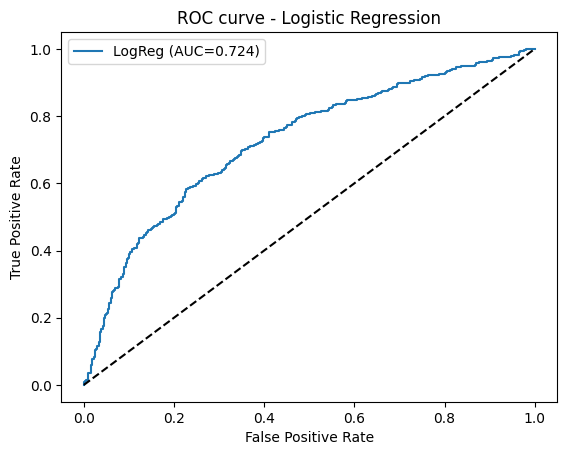

In [12]:
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.plot(fpr, tpr, label=f"LogReg (AUC={auc_lr:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Logistic Regression")
plt.legend()
plt.show()


In [13]:
# PCA to reduce dimensionality before KMeans
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

X_train_pca.shape, X_test_pca.shape


((4800, 100), (1200, 100))

In [15]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_pca)

cluster_train = kmeans.predict(X_train_pca)

# majority-vote mapping from clusters -> labels
mapping = {}
for c in [0, 1]:
    mask = (cluster_train == c)
    majority_label = np.bincount(y_train[mask]).argmax()
    mapping[c] = majority_label
mapping


{0: np.int64(1), 1: np.int64(0)}

In [16]:
cluster_test = kmeans.predict(X_test_pca)
y_pred_km = np.vectorize(mapping.get)(cluster_test)

acc_km = accuracy_score(y_test, y_pred_km)
cm_km  = confusion_matrix(y_test, y_pred_km)

print("KMeans (PCA=100, 2 clusters) accuracy :", acc_km)
print("Confusion matrix:\n", cm_km)


KMeans (PCA=100, 2 clusters) accuracy : 0.5866666666666667
Confusion matrix:
 [[497 103]
 [393 207]]


In [17]:
results_img = pd.DataFrame({
    "Model": ["Logistic Regression (tuned)", "KMeans + PCA(100)"],
    "Accuracy": [acc_lr, acc_km],
    "AUC": [auc_lr, np.nan]
})
results_img


,Model,Accuracy,AUC
0,Logistic Regression (tuned),0.665833,0.724147
1,KMeans + PCA(100),0.586667,NaN
